# Enhanced protein isoform characterization through long-read proteogenomics 
## Figure 3 
#### Ben Jordan


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import matplotlib
import os, sys
import dataframe_image as dfi

# currentdir = os.path.dirname(os.path.realpath(__file__))
# parentdir = os.path.dirname(currentdir)
# sys.path.append(parentdir)
import config, data_loader
from data_loader import genes_in_hiconf_space, accs_in_hiconf_space


matplotlib.rc('font', **config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')



## Fig3c, Bar chart showing the frequency of protein isoform classifications for the protein database (total ~45,000 entries).

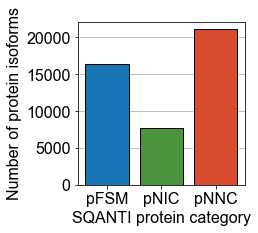

<Figure size 432x288 with 0 Axes>

In [2]:

filtered_database_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_filter/{config.EXPERIMENT_NAME}.classification_filtered.tsv' # ~45K 
pclassification_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_classification/{config.EXPERIMENT_NAME}_unfiltered.protein_classification.tsv'

pclass_all = pd.read_table(pclassification_file)


prots = pd.read_table(filtered_database_file)
prots['gene'] = prots['pr_gene']

structural_sizes = prots.groupby('pclass').size()
total = len(pclass_all)
# total = structural_sizes.sum()
structural_percent = structural_sizes / total * 100
structural_category_stats = pd.merge(structural_sizes.reset_index(), structural_percent.reset_index(), on = 'pclass')
structural_category_stats.columns = ['structural_category', 'N', 'percent']

# output bar plot of sqanti categories
fig, ax = plt.subplots(figsize=(3,3))
struc_simple= structural_category_stats[structural_category_stats.structural_category.isin(['pFSM','pNIC', 'pNNC'])]
colors = []
for cat in struc_simple['structural_category']:
    colors.append(config.sqanti_protein_colors[cat])
ax.bar(struc_simple.structural_category, struc_simple.N, edgecolor='black', linewidth=1, color=colors, zorder=20)
ax.grid(axis='y', zorder=0)
ax.set_xlabel('SQANTI protein category')
ax.set_ylabel('Number of protein isoforms')
plt.savefig('plot/Fig3c_bar_sqanti_cats_all.pdf', bbox_inches='tight')
plt.show()
plt.clf()
# output source data
struc_simple.columns = ['protein_structural_category', 'N', 'percent']
structural_category_stats.to_csv('stats/Fig3c_sqanti_cats_all.tsv', sep='\t', index=None)

## Fig 3d, Number of genes in each category described in Figure 1b-f, classified by the relationship between reference isoforms and predicted sample protein isoforms (genes in high confidence space)

<ipython-input-3-774c6c55f238>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Match', 'Subset', 'Superset', 'Partial\nOverlap', 'Distinct'))


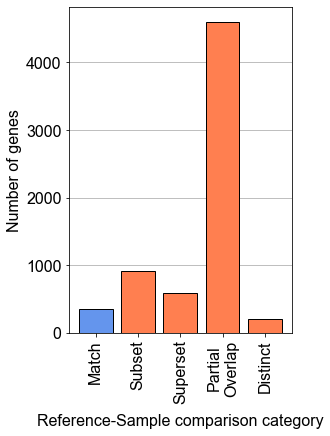

<Figure size 432x288 with 0 Axes>

In [3]:
pclassification_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_classification/{config.EXPERIMENT_NAME}_unfiltered.protein_classification.tsv'
gencode_protein_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/gencode_db/gencode_isoname_clusters.tsv'

pclass_all = pd.read_table(pclassification_file)

# Preprocess Data
pclass_all = pclass_all[['pb', 'pr_gene', 'protein_classification_base']]
pclass_all.rename(columns = {
    'pr_gene': 'gene',
    'protein_classification_base': 'pclass'
}, inplace=True)

pclass_all['is_high_confidence'] = pclass_all['pb'].apply(lambda pb: pb in data_loader.accs_in_hiconf_space)
pclass = pclass_all[pclass_all['is_high_confidence']]
confidence = 'high_confidence'

pfsm = pclass[pclass['pclass']=='pFSM']

gencode_protein = pd.read_table(gencode_protein_file)
gencode_protein['gene'] = gencode_protein.apply(lambda x: '-'.join(x.repr_isoname.split('-')[:-1]), axis = 1)

# Get Refernce-Sample complexity category information
def compare_isoforms(row):
    if row['pb_size']==0:
        return 'missing'
    elif row['pfsm_size']==0:
        return 'distinct'
    elif row['pb_size']==row['pfsm_size']:
        if row['gencode_size']==row['pfsm_size']:
            return 'match' 
        elif row['gencode_size'] > row['pfsm_size']:
            return 'subset'
    else:
        if row['gencode_size']==row['pfsm_size']:
            return 'superset'
        else:
            return 'partial match'

def determine_reference_sample_complexity_category(gencode_protein, pclass):
    gencode_sizes = (
        gencode_protein
            .groupby('gene').size()
            .reset_index(name='gencode_size')
    )
    pb_pfsm_sizes=(
        pfsm
            .groupby('gene').size()
            .reset_index(name='pfsm_size')
    )
    pb_all_sizes=(
        pclass
            .groupby('gene').size()
            .reset_index(name='pb_size')
    )

    ref_samp_cat = (
        gencode_sizes
            .merge(pb_pfsm_sizes, on='gene', how='outer')
            .merge(pb_all_sizes ,on='gene', how='outer')
            .fillna(0)
    )

    ref_samp_cat = ref_samp_cat[~ref_samp_cat.gene.str.startswith('novelGene_')]
    ref_samp_cat['isoform_category'] = ref_samp_cat.apply(compare_isoforms, axis=1)

    return ref_samp_cat

ref_samp_cat = determine_reference_sample_complexity_category(gencode_protein, pclass)
ref_samp_cat.to_csv('stats/Fig3d_ref_sample_cats.tsv', sep='\t', index=False)

# Plot refence-sample complexity summary bar chart
def plot_ref_samp_complexity_summary(ref_samp_cat):
    ref_samp_cat_summary = ref_samp_cat.groupby('isoform_category').size().to_frame('number_of_genes')
    ref_samp_cat_summary.to_csv('stats/Fig3d_ref_sample_cats_summary_stats.tsv', sep='\t',)

    ref_samp_cat_summary.drop(index='missing',inplace=True)
    color = ['cornflowerblue', 'coral', 'coral', 'coral', 'coral']
    ref_samp_cat_summary = ref_samp_cat_summary.reindex(['match','subset','superset', 'partial match', 'distinct'])

    fig, ax = plt.subplots(figsize=(4,6))
    plt.bar(ref_samp_cat_summary.index, ref_samp_cat_summary.number_of_genes, color=color, edgecolor='black', zorder=10)
    ax.set_xticklabels(('Match', 'Subset', 'Superset', 'Partial\nOverlap', 'Distinct'))
    plt.grid(zorder=0, axis='y')
    plt.xticks(rotation=90)
    plt.xlabel('Reference-Sample comparison category', labelpad=10)
    plt.ylabel('Number of genes')
    plt.savefig(f'plot/Fig3d_ref_sample_cats_{confidence}.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
plot_ref_samp_complexity_summary(ref_samp_cat)


## Fig3e Comparison of the number of sample versus reference isoforms for Subset and Superset isoform comparison scenarios. pFSM, protein full splice match; pNIC, protein novel in catalog; pNNC, protein novel not in catalog.


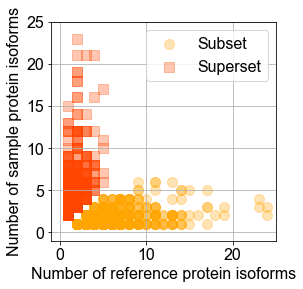

In [4]:
# Plot reference-sample complexity subset vs superset
# scatter 
def plot_scatter_subset_superset(ref_samp_cat):
    subset = ref_samp_cat[ref_samp_cat['isoform_category']=='subset']
    superset = ref_samp_cat[ref_samp_cat['isoform_category']=='superset']

    # plot scsatter subset/superset reference/sample isoform numbers
    fig, ax = plt.subplots(figsize=(4.03,4.03))
    plt.scatter(subset.gencode_size, subset.pb_size, s=100, alpha=0.3, c='orange', marker='o', label='Subset')
    plt.scatter(superset.gencode_size, superset.pb_size, s=100, alpha=0.3, c='orangered', marker='s', label='Superset')
    plt.xlabel('Number of reference protein isoforms')
    plt.ylabel('Number of sample protein isoforms')
    # plt.axis( scaled')
    plt.ylim(-1,25)
    plt.xlim(-1,25)
    ax.legend()
    plt.grid()
    plt.savefig(f'plot/Fig3e_superset_ref_vs_samp_iso_numbers_{confidence}.pdf', bbox_inches='tight')
    plt.show()

    subset[['gene','gencode_size','pb_size']].to_csv(f'stats/Fig3e_subset_sizes_{confidence}.tsv', sep='\t')
    superset[['gene','gencode_size','pb_size']].to_csv(f'stats/Fig3e_superset_sizes_{confidence}.tsv', sep='\t')

plot_scatter_subset_superset(ref_samp_cat)